# T-Mobile Customer Data Analysis

ideas:
- customer interaction data, customer survey data
- join two data by account id, connect the interaction reason, time spent, customer comments and improvement opportunities, and customers current rate plan 
- text analysis on customer survey's two text columns 
- calculate customer NPS and company NPS

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk
import string
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from nltk.util import ngrams

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rouzi.bai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rouzi.bai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [236]:
os.chdir("G:\HRIS\Bai")

In [237]:
interaction = pd.read_csv('customer_interactions.csv')
survey = pd.read_csv('customer_surveys.csv')

In [238]:
interaction.shape

(206829, 24)

In [239]:
survey.shape

(7095, 17)

In [7]:
interaction.columns

Index(['ACCOUNT_ID_', 'JourneyStartDate', 'Duration', 'JourneyReasonID',
       'StepNumber', 'InteractionStart', 'Channel', 'Reason', 'TimeSpentInSec',
       'InteractionCount', 'DaysUntilNextStep', 'HoursUntilNextStep',
       'SwitchedToThisChannel_Ind', 'SameAsLastReason_Ind',
       'SwitchedChannelSameReason_Ind', 'TransferCount', 'RetailCallsToCare',
       'TransactionID', 'StepEffort', 'InteractionID', 'MsgTransferCount',
       'Event_Ind', 'ChannelActivityID', 'ChannelName'],
      dtype='object')

In [240]:
survey.columns

Index(['ACCOUNT_ID_', 'ResponseId', 'RecordedDate_x', 'StartDate', 'EndDate',
       'Progress', 'UserLanguage', 'CUSTOMER_EFF_JOUR_NPS_GROUP',
       'CUSTOMER_EFF_JOUR', 'COMPANY_EFF_JOUR_NPS_GROUP', 'COMPANY_EFF_JOUR',
       'ACCOUNT_ID', 'ACCOUNT_NO_OF_VOICE_LINES', 'JOURNEY_SAT_OPEN',
       'CONTACT_METH_OPTION', 'IMPROVEMENT_OPP', 'CURRENT_RATE_PLAN_DESC'],
      dtype='object')

In [241]:
data = pd.merge(interaction, survey, on = 'ACCOUNT_ID_', how = 'left' )

In [242]:
data.shape

(206925, 40)

In [245]:
data.duplicated().value_counts()

False    206649
True        276
dtype: int64

In [11]:
len(data) - len(interaction)

108

In [246]:
206829 - 206649

180

## Top interaction reasons

In [12]:
result1 = data.groupby(['Reason'])['ACCOUNT_ID_'].count().nlargest(20)
print(result1)

Reason
Unknown                              72122
Manage Acct / Phone Nbr              28256
Payment                              15033
Billing                              14682
Usage                                13059
Payment Arrangement                  10823
Manage PWD/PIN                        9458
Device - Shop / Prereg                7788
Purchase Device / Equipment           6775
Device / Equipment                    5247
Services / Features                   4244
Rate Plan Info/Support                2886
Accessories                           2669
Chg of Responsibility / Auth User     1609
Add a person / device (line)          1252
Support                               1251
Connectivity/Coverage                 1063
EIP/Lease                              960
AutoPay                                943
Rate Plan Change                       838
Name: ACCOUNT_ID_, dtype: int64


# Average time spent (in minutes) per category (reason)

In [13]:
result2 = round(data.groupby(['Reason'])['TimeSpentInSec'].agg('mean').nlargest(20)/60,1)
print(result2)

Reason
Device / Equipment                  23.8
Suspend / Restore - Voluntary       14.3
Rate Plan Info/Support              12.0
EIP/Lease                           11.9
Device/Equipmt - Return/Exchg       11.3
Apps or Website                     11.2
Device Unlock                       10.6
Fraud                               10.6
Device / Equip/ Network Issues      10.4
Device insurance                     9.9
Suspend / Restore                    9.8
Other Devices / IoT                  9.7
Escalation or Complaint              9.5
Device / Equip - Software Update     9.3
Unknown                              8.9
Activate / Migration                 8.7
Connectivity/Coverage                8.6
Usage                                7.3
AutoPay                              6.9
Purchase Device / Equipment          6.1
Name: TimeSpentInSec, dtype: float64


## Among the customers who have interacted with T-Mobile, what are their current plans?

In [14]:
result3 = data.groupby(['CURRENT_RATE_PLAN_DESC'])['ACCOUNT_ID_'].count().nlargest(20)
print(result3)

CURRENT_RATE_PLAN_DESC
T-Mobile ONE                     54489
Magenta (2 line)                 14453
T-Mobile ONE Unlimited 55 3L     11506
T-Mobile ONE Military 2+          9581
2 Lines TMO ONE All In Promo      9235
Magenta Plus                      8706
T-Mobile Essentials 2+            8558
SC FAM UNL TT+D 4 lines incl.     6798
T-Mobile ONE Unlimited 55         6413
Magenta Military (2 line)         5239
Magenta Unlimited 55 (2 line)     4724
SimpleChoice Val FAM UnlTT+D      4699
SC NA UTT+10GB each 4 Lines       4055
T-Mobile ONE w/ONE+ Family        3695
Magenta                           3257
SC FAM UNL TT+D 2 lines incl.     2865
T-Mobile Essentials               2398
Magenta 1st Responder 2L          2268
SC FM UTT+6GB for 4 lines         2255
Magenta Unlimited 55              1965
Name: ACCOUNT_ID_, dtype: int64


## the most common contact method


In [219]:
result4 = data.groupby(['CONTACT_METH_OPTION'])['ACCOUNT_ID_'].count().nlargest(20)
print(result4)

CONTACT_METH_OPTION
Called T-Mobile                                                                                                     82562
Visited a store                                                                                                     33413
Interacted with a T-Mobile App                                                                                      21576
Went to T-Mobile.com                                                                                                11059
Called T-Mobile,Visited a store                                                                                      8176
Used chat feature on website                                                                                         8020
Called T-Mobile,Interacted with a T-Mobile App                                                                       4384
Called T-Mobile,Went to T-Mobile.com                                                                                 2950
Call

In [231]:
data['CONTACT_METH_OPTION'].nunique()

90

In [232]:
result5 = data.groupby(['CONTACT_METH_OPTION'])['CUSTOMER_EFF_JOUR'].agg('mean').sort_values(ascending=False).head(20)
print(result5)


CONTACT_METH_OPTION
Went to T-Mobile.com,Sent text message,Interacted with a T-Mobile App,Used chat feature on website                        10.000000
Visited a store,Interacted with a T-Mobile App,Messaged on social media,Used chat feature on website                      10.000000
Went to T-Mobile.com,Visited a store,Sent text message                                                                    10.000000
Called T-Mobile,Visited a store,Sent text message,Messaged on social media,Used chat feature on website                   10.000000
Interacted with a T-Mobile App,Messaged on social media,Used chat feature on website                                      10.000000
Called T-Mobile,Went to T-Mobile.com,Messaged on social media                                                             10.000000
Called T-Mobile,Went to T-Mobile.com,Visited a store,Sent text message,Messaged on social media                           10.000000
Called T-Mobile,Sent text message,Interacted with a T-Mo

## Calculate Customer NPS & Company NPS

In [15]:
result4 = data.groupby(['CUSTOMER_EFF_JOUR_NPS_GROUP'])['ACCOUNT_ID_'].count() / len(data)
print(result4)
## customer NPS = -20%

CUSTOMER_EFF_JOUR_NPS_GROUP
Detractor    0.538164
Passive      0.121042
Promoter     0.339867
Name: ACCOUNT_ID_, dtype: float64


In [16]:
result5 = data.groupby(['COMPANY_EFF_JOUR_NPS_GROUP'])['ACCOUNT_ID_'].count() / len(data)
print(result5)
## company NPS = 17%

COMPANY_EFF_JOUR_NPS_GROUP
Detractor    0.350764
Passive      0.132963
Promoter     0.515345
Name: ACCOUNT_ID_, dtype: float64


In [19]:
table1 = round(pd.crosstab(data['COMPANY_EFF_JOUR_NPS_GROUP'], data['CUSTOMER_EFF_JOUR_NPS_GROUP'], margins = True, normalize= True),2)
print(table1)

CUSTOMER_EFF_JOUR_NPS_GROUP  Detractor  Passive  Promoter   All
COMPANY_EFF_JOUR_NPS_GROUP                                     
Detractor                         0.20     0.04      0.11  0.35
Passive                           0.07     0.04      0.02  0.13
Promoter                          0.27     0.04      0.21  0.52
All                               0.54     0.12      0.34  1.00


In [48]:
# which contact method had the better NPS 
#








CONTACT_METH_OPTION          Called T-Mobile  \
CUSTOMER_EFF_JOUR_NPS_GROUP                    
Detractor                           0.219168   
Passive                             0.048908   
Promoter                            0.128541   
All                                 0.396617   

CONTACT_METH_OPTION          Called T-Mobile,Interacted with a T-Mobile App  \
CUSTOMER_EFF_JOUR_NPS_GROUP                                                   
Detractor                                                          0.008034   
Passive                                                            0.002678   
Promoter                                                           0.006202   
All                                                                0.016913   

CONTACT_METH_OPTION          Called T-Mobile,Interacted with a T-Mobile App,Messaged on social media  \
CUSTOMER_EFF_JOUR_NPS_GROUP                                                                            
Detractor                   

## Customer NPS Detractor Text Analysis

- JOURNEY_SAT_OPEN
- IMPROVEMENT_OPP


In [27]:
pd.set_option('display.max_colwidth',None)

In [208]:
detractor = survey[(survey['CUSTOMER_EFF_JOUR_NPS_GROUP'] == 'Detractor') & (survey['COMPANY_EFF_JOUR_NPS_GROUP'] == 'Detractor')].IMPROVEMENT_OPP.astype(str)
print(len(detractor))

promoter = survey[(survey['CUSTOMER_EFF_JOUR_NPS_GROUP'] == 'Promoter') & (survey['COMPANY_EFF_JOUR_NPS_GROUP'] == 'Promoter')].JOURNEY_SAT_OPEN.astype(str)
print(len(promoter))

1459
1258


In [203]:
NLTK_stop_words_list=stopwords.words('english')
print(NLTK_stop_words_list)
print("Total numbers of stop words are ")
print(len(NLTK_stop_words_list))

custom_stop_word_list = ['nan', 'feel','like','customer','service','would','make','sure'
                         ]
final_stopword_list = custom_stop_word_list + NLTK_stop_words_list

print(len(final_stopword_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [209]:
docs =[doc for doc in promoter ]
docs = (' '.join(filter(None, docs))).lower()
tokens = word_tokenize(docs)
tokens = [t for t in tokens if t not in final_stopword_list]
word_l = WordNetLemmatizer()
tokens = [word_l.lemmatize(t) for t in tokens if t.isalpha()]

In [210]:
n_grams = list(ngrams(tokens, 2)) 
counter = Counter(n_grams)
common_ngrams = counter.most_common(20)
common_ngrams

[(('issue', 'resolved'), 19),
 (('new', 'phone'), 14),
 (('resolve', 'issue'), 13),
 (('payment', 'arrangement'), 12),
 (('answered', 'question'), 10),
 (('every', 'time'), 10),
 (('extremely', 'helpful'), 8),
 (('right', 'away'), 8),
 (('resolved', 'issue'), 8),
 (('answer', 'question'), 8),
 (('new', 'device'), 7),
 (('solve', 'problem'), 7),
 (('took', 'time'), 7),
 (('pay', 'bill'), 7),
 (('taken', 'care'), 6),
 (('person', 'helped'), 6),
 (('billing', 'issue'), 6),
 (('phone', 'call'), 6),
 (('every', 'month'), 6),
 (('sale', 'person'), 6)]

In [40]:
vectorizer2= CountVectorizer(analyzer = 'word', ngram_range = (2,2), stop_words = final_stopword_list)
X2 = vectorizer2.fit_transform(detractor)
tri_grams = vectorizer2.get_feature_names()

In [41]:
# Checking strings end with the word
newlist = []
for t in tri_grams:
    if t.endswith('issue'):
        newlist.append(t)
print(newlist)

['10 issue', 'advise issue', 'although issue', 'anyways issue', 'apple issue', 'area issue', 'arrangement issue', 'back issue', 'billing issue', 'bothered issue', 'call issue', 'callback issue', 'called issue', 'calls issue', 'card issue', 'care issue', 'causing issue', 'charged issue', 'clear issue', 'cleared issue', 'complicated issue', 'computer issue', 'connection issue', 'continue issue', 'corrected issue', 'coverage issue', 'credit issue', 'days issue', 'deal issue', 'dns issue', 'employees issue', 'every issue', 'exactly issue', 'excellent issue', 'expedited issue', 'explained issue', 'figure issue', 'financial issue', 'first issue', 'fix issue', 'fixed issue', 'fixing issue', 'get issue', 'got issue', 'handled issue', 'help issue', 'helped issue', 'helpful issue', 'horrible issue', 'however issue', 'instead issue', 'knew issue', 'know issue', 'level issue', 'log issue', 'looked issue', 'lot issue', 'minor issue', 'mobile issue', 'never issue', 'part issue', 'particular issue', 

In [160]:
# Checking strings start with the word
r = re.compile('monthly')
newlist = list(filter(r.match, tri_grams))
print(newlist)

['monthly bill', 'monthly credit', 'monthly expenditures', 'monthly family', 'monthly fee', 'monthly first', 'monthly line', 'monthly pay', 'monthly payment', 'monthly payments', 'monthly plan', 'monthly rate', 'monthly statement', 'monthly thanks']


In [305]:
# Checking documents contain certain string
pattern = 'password'
filter_values = promoter[promoter.str.contains(pattern, case = False, na = False)]
print(filter_values)

1689    I have not been able to log in to my account since Sept. Every month I have to call to pay my bill. They try and resolve the issue, but next month same problem. At this point I refuse to change my password again. I will not pay a fee to pay my bill and I can not change my plan because I can not log in. I have to consider changing carriers, my account is nothing to T-Mobile, but being able to log in with the log in information of my choosing means everything to me.
4018                                                                                                                           Every time I try to log on the website to make a payment I go through all security questions regardless if my password is correct or not. I would understand going through the questions if my password is incorrect, but it happens every time. Plus I have to get the verification code through text as well. How to avoid 10 steps just to make a payment?
Name: JOURNEY_SAT_OPEN, dtype: object


## document classification

In [259]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np

In [260]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

# parse commandline arguments
op = OptionParser()
op.add_option("--lsa",
              dest="n_components", type="int",
              help="Preprocess documents with latent semantic analysis.")
op.add_option("--no-minibatch",
              action="store_false", dest="minibatch", default=True,
              help="Use ordinary k-means algorithm (in batch mode).")
op.add_option("--no-idf",
              action="store_false", dest="use_idf", default=True,
              help="Disable Inverse Document Frequency feature weighting.")
op.add_option("--use-hashing",
              action="store_true", default=False,
              help="Use a hashing feature vectorizer")
op.add_option("--n-features", type=int, default=10000,
              help="Maximum number of features (dimensions)"
                   " to extract from text.")
op.add_option("--verbose",
              action="store_true", dest="verbose", default=False,
              help="Print progress reports inside k-means algorithm.")

print(__doc__)
op.print_help()

def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.


In [291]:
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(n_features=opts.n_features,
                                   stop_words=final_stopword_list, alternate_sign=False,
                                   norm=None)
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(n_features=opts.n_features,
                                       stop_words=final_stopword_list,
                                       alternate_sign=False, norm='l2')
else:
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,
                                 min_df=2, stop_words=final_stopword_list,
                                 use_idf=opts.use_idf)
X = vectorizer.fit_transform(promoter)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))

    print()



done in 0.038908s
n_samples: 1258, n_features: 632



In [292]:
print(X.shape)

(1258, 632)


In [297]:
true_k = 5

In [298]:
if opts.minibatch:
    km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, verbose=opts.verbose, random_state = 1234)
else:
    km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=opts.verbose, random_state = 1234)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()
# This measure has range [-1,1], if it's near 1 indicate that the sample is far away from the neighboring clusters. 
# Close to 0 indicate that the sample is on or very close to the decision boundary.
# Negative values indicate that the samples might have been assigned to the wrong cluster.

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

print()

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_size=1000, n_clusters=5, n_init=1,
                random_state=1234, verbose=False)
done in 0.076s

Silhouette Coefficient: 0.166



In [299]:
if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: 10 excellent yet failed fees fee fault fast far fantastic
Cluster 1: nice helpful helped person professional rep good support understanding representative
Cluster 2: password every questions payment time incorrect log plus happens website
Cluster 3: helpful rep knowledgeable professional person staff polite sales courteous friendly
Cluster 4: great good phone easy mobile problem excellent resolved help always


In [300]:
labels = km.predict(X)
freq =Counter(labels)
freq.most_common()

[(4, 1140), (3, 51), (0, 42), (1, 24), (2, 1)]

Text(0, 0.5, 'Number of Text')

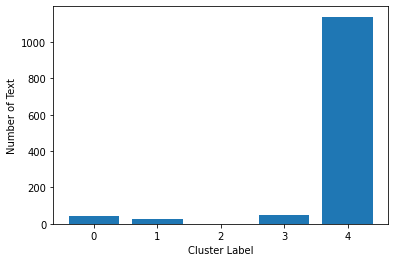

In [301]:
plt.bar(freq.keys(), freq.values())
plt.xlabel("Cluster Label")
plt.ylabel("Number of Text")

In [187]:
inertias = []
mapping = {}
K = range(1, 25)

for k in K:
	km.fit(X)
	inertias.append(km.inertia_) #the sum of squared distances of samples to their closest cluster center.
	mapping[k] = km.inertia_

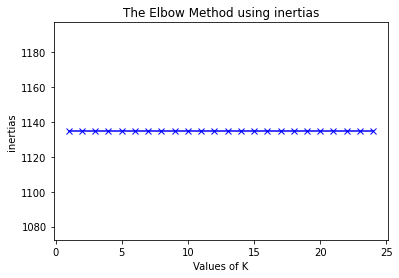

In [188]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('inertias')
plt.title('The Elbow Method using inertias')
plt.show()

## What made a customer detractor

## What made a customer promoter